In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Get hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    features = hog(img, orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    block_norm= 'L2-Hys',
                    transform_sqrt=False, 
                    visualise=vis, feature_vector=feature_vec)
    return features


# get hog features for all image channels
def get_hog_feature_all_channels(img, orient, pix_per_cell, cell_per_block):
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hf_ch1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hf_ch2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hf_ch3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    return hf_ch1, hf_ch2, hf_ch3

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', include_spatial=True, spatial_size=(32, 32),
                     include_hist=True, hist_bins=32, hist_range=(0, 256),
                     include_hog=True, orient=11, pix_per_cell=8, cell_per_block=3, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if include_spatial:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if include_hist:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        # include hog features
        if include_hog:
            hf1, hf2, hf3 = get_hog_feature_all_channels(feature_image, orient, pix_per_cell, cell_per_block)
            '''hog_features, hog_img = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=feature_vec)'''
            hog_features = np.hstack((hf1.ravel(), hf2.ravel(), hf3.ravel()))
            img_features.append(hog_features)
        #print(spatial_features.shape, hist_features.shape, hog_features.shape, feature_image.shape, hf1.shape)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features


In [3]:
# Read in car and non-car images
car_images = glob.glob('./train/vss/cars1/*.jpeg')
notcar_images = glob.glob('./train/nvs/notcars2/*.jpeg')
cars = []
notcars = []
for image in car_images:
        cars.append(image)
for image in notcar_images:
        notcars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 16
histbin = 32
color_space = 'LUV'
orient = 11
pix_per_cell = 8
cell_per_block=2
t0=time.time()
car_features = extract_features(cars, cspace='LUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
notcar_features = extract_features(notcars, cspace='LUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
t1=time.time()
print(round(t1-t0, 2), 'Seconds to extract features')
print(len(car_features), len(notcar_features))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
print(len(X), len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=rand_state)
print(X_train.shape)
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(y_test)
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

3.91 Seconds to extract features
397 400
797 797
(637, 7332)
Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 7332
0.12 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.]
For these 160 labels:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 

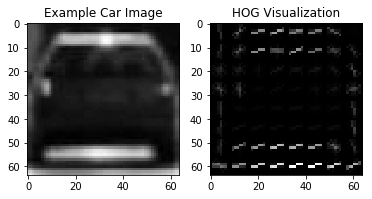

In [4]:
orient = 11
pix_per_cell = 8
cell_per_block=2

img = cv2.imread(cars[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img[:,:,0], cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def get_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop[0] is None:
        y_start_stop = [img.shape[0]//2, img.shape[0]]
    # Compute the span of the region to be searched
    # Compute the number of pixels per step in x/y
    pxp_xstep = xy_window[0]*(1-xy_overlap[0])
    pxp_ystep = xy_window[1]*(1-xy_overlap[1])
    # Compute total number of windows in x and y
    x_steps = int(( (x_start_stop[1] - x_start_stop[0]) / pxp_xstep ) - 1)
    y_steps = int(( (y_start_stop[1] - y_start_stop[0]) / pxp_ystep ) - 1)
    # Compute the number of windows in x/y
    totat_windows = x_steps*y_steps
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    cy = y_start_stop[0]
    for y in range(y_steps):
        cx = x_start_stop[0]
        for x in range(x_steps):
            top_left = (int(cx), int(cy))
            bottom_right = (int(cx + xy_window[0]), int(cy + xy_window[1]))
            window_list.append((top_left, bottom_right))
            cx += pxp_xstep
        cy += pxp_ystep
    # Return the list of windows
    return window_list

In [6]:
class Window:
    def __init__(self):
        self.windows = []
        self.hog_features = None
        self.predictions = []
        self.hot_indexes = []

# get prediction for each window
def get_predictions(classifier, Xscaler, img, window_data, y_start_pos, x_start_pos, cell_per_block, pix_per_cell,
                    inc_spatial, inc_hist, spatial_size = (32, 32), hist_bins = 32, hist_range = (0, 256)):
    predictions = []
    hog_features = window_data.hog_features
    all_windows = window_data.windows
    hog_f1 = hog_features[0]
    hog_f2 = hog_features[1]
    hog_f3 = hog_features[2]
    #hog_blocks_x = img.shape[1]//(hog_f1.shape[0]+1)
    # Convert LUV to HSV format for spatial and color histogram features
    rgb_img = cv2.cvtColor(img, cv2.COLOR_Luv2RGB)
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    # loop over windows to get features for
    print("About to Loop")
    for i in range(len(all_windows)):
        win_features = []
        # image patch for which to get features
        win = all_windows[i].astype(int)
        tlt, brt = win
        #print(win)
        img_win = np.copy(hsv_img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1])
        '''print(tlt[1], brt[1]+1, tlt[0], brt[0]+1, img_win.shape)
        plt.imshow(img_win)
        plt.show()'''
        img_win = cv2.resize(img_win, (64, 64))
        # get spatial features
        if inc_spatial:
            spf = bin_spatial(img_win, size=spatial_size)
            win_features.append(spf)
        # get color histogram features
        if inc_hist:
            hsf = color_hist(img_win, nbins=hist_bins, bins_range=hist_range)
            win_features.append(hsf)
        # get hog features
        hxs = int((tlt[0] + 1 - x_start_pos)//pix_per_cell)    #cell no. equals block no.
        hys = int((tlt[1] + 1 - y_start_pos)//pix_per_cell)
        hxe = int((brt[0] + 1 - x_start_pos)//pix_per_cell) - cell_per_block + 1   #total blocks in window range
        hye = int((brt[1] + 1 - y_start_pos)//pix_per_cell) - cell_per_block + 1
        
        # check for proper shape, modify 6 to calculation with parameters
        shp = hog_f1[hys:hye, hxs:hxe].shape
        if shp[0] != shp[1] or shp[0] < 6:
            predictions.append(0)
            continue
        if hxe > hog_f1.shape[1] or hye > hog_f1.shape[0]:
            predictions.append(0)
            continue
        hog_ch1 = hog_f1[hys:hye, hxs:hxe].ravel()
        hog_ch2 = hog_f2[hys:hye, hxs:hxe].ravel()
        hog_ch3 = hog_f3[hys:hye, hxs:hxe].ravel()
        #print(hys, hye, hxs, hxe, hog_f1[hys:hye, hxs:hxe].shape)
        hgf = np.hstack((hog_ch1, hog_ch2, hog_ch3))
        win_features.append(hgf)
        #features.append(win_features)
        #print(win_features[0].shape, win_features[1].shape, win_features[2].shape, x_start_pos)
        #break
        test_features = Xscaler.transform(np.hstack((win_features[0], win_features[1], win_features[2])).reshape(1, -1))
        predictions.append(classifier.predict(test_features))
    return np.array(predictions)

# find cars in given image by using the given trained classifier
def find_cars(img, classifier, Xscaler):
    hot_img = np.zeros_like(img)
    # hog cell details
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    spatial = 16
    hbins = 32
    overlap = 0.5
    # multi-window sizes, multiples of hog cell size to ease custom feature extraction
    trained_win_size = 64
    win_sizes = [128, 64, 32, 16]
    # y-axis scan range
    y_fullrange_img = [((img.shape[0]//2)//64)*64, img.shape[0]-48]
    y_len = y_fullrange_img[1] - y_fullrange_img[0]
    # range_offsets along x-axis for each window
    x_offset = [0, 64, 128, 256]
    # range_offsets along y-axis for each window
    y_offset = [0, 32, 64, 64]
    # list of windows for each window size
    all_windows = {128: Window(),
                  64: Window(),
                  32: Window(),
                  16: Window()}
    
    # convert to LUV colorspace
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    print(img.shape)
    # find boxes and hog features for entire area to be scanned for each window size
    for i in range(len(win_sizes)):
        print("start again")
        features = []
        # scan range for y-axis
        y_range_img = [y_fullrange_img[0] + y_offset[i], y_fullrange_img[1] - y_offset[i]]
        # get x range for search
        x_range_img = [x_offset[i], image.shape[1] - x_offset[i]]
        # get all the windows in this range
        all_windows[win_sizes[i]].windows = get_windows(img, x_start_stop=x_range_img, y_start_stop=y_range_img, 
                                        xy_window=(win_sizes[i], win_sizes[i]), xy_overlap=(overlap, overlap))
        # resize the image so that current window size scales to 64x64 px, i.e, the size of images in training data
        scale = trained_win_size/win_sizes[i]
        # image patch for which to get hog features
        window_clip = np.copy(img[y_range_img[0]:y_range_img[1]+1, x_range_img[0]:x_range_img[1]+1])
        # resize to scale to window size of 64x64 px
        #print(win_sizes[i], y_range_img, window_clip.shape, scale)
        window_clip = cv2.resize(window_clip, (int(window_clip.shape[1]*scale), int(window_clip.shape[0]*scale)))
        res_img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
        scaled_ystart = y_range_img[0]*scale
        scaled_xstart = x_range_img[0]*scale
        # get hog features for the entire patch
        all_windows[win_sizes[i]].hog_features = get_hog_feature_all_channels(window_clip, orient, pix_per_cell, cell_per_block)
        print(y_range_img, x_range_img, len(all_windows[win_sizes[i]].windows))
        print(all_windows[win_sizes[i]].hog_features[0].shape)
        all_windows[win_sizes[i]].windows = np.asarray(all_windows[win_sizes[i]].windows)*scale

        all_windows[win_sizes[i]].predictions = get_predictions(classifier, Xscaler, res_img, all_windows[win_sizes[i]],
                                                        scaled_ystart, scaled_xstart, cell_per_block,
                                                        pix_per_cell, inc_spatial=True, inc_hist=True,
                                                        spatial_size = (spatial, spatial),
                                                        hist_bins = hbins, hist_range = (0, 256))
        # scale back windows to original size
        all_windows[win_sizes[i]].windows = np.asarray(all_windows[win_sizes[i]].windows)//scale
        all_windows[win_sizes[i]].windows = all_windows[win_sizes[i]].windows.astype(int)
        
        # get indexes on non-zero(car) predictions
        all_windows[win_sizes[i]].hot_indexes = np.array((all_windows[win_sizes[i]].predictions.nonzero())[0])
        # add heat to hot_img
        #print(all_windows[win_sizes[i]].hot_indexes)
        cnt=0
        for ind in all_windows[win_sizes[i]].hot_indexes:
            # get corners x-y from hot windows
            tlt, brt = all_windows[win_sizes[i]].windows[ind]
            #hot_img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1] = 1
            cv2.rectangle(hot_img,(tlt[0], tlt[1]),(brt[0],brt[1]),(0,0,255),6) 
        plt.imshow(hot_img, cmap="gray")
        plt.show()
        break
    # remove unwanted heat by thresholding
    

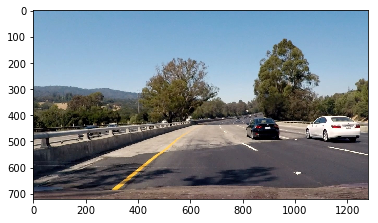

(720, 1280, 3)
start again
[320, 672] [0, 1280] 76
(21, 79, 2, 2, 11)
About to Loop


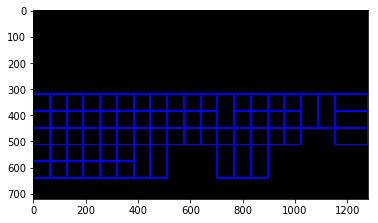

In [7]:
image = cv2.imread('./test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

find_cars(image, svc, X_scaler)
